In [1]:
%cd ..
%pwd

/Users/nebula/Documents/MS-DataScience/Fall-2024/DL(DS-677)/Project/TradeForecast


/Users/nebula/Documents/MS-DataScience/Fall-2024/DL(DS-677)/Project/TradeForecast/.venv/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


'/Users/nebula/Documents/MS-DataScience/Fall-2024/DL(DS-677)/Project/TradeForecast'

In [2]:
from tradeforecast import Scrapper

ticker = 'AAPL'
scrapper = Scrapper(ticker)

exported_fnames_dict = scrapper.export_historic_data()
exported_fnames_dict

[*********************100%***********************]  1 of 1 completed


{'AAPL': 'AAPL_1d_max_(None-None).csv'}

In [3]:
from tradeforecast.augmentation import DataEntryPoint, Indicators, FeatureEngg, RNNDataset, train_test_split
import polars as pl

data_entry = DataEntryPoint(exported_fnames_dict['AAPL'])

lf = data_entry.data.drop_nulls()
lf.head().collect()

Datetime,Close,High,Low,Open,Volume
"datetime[μs, EST]",f64,f64,f64,f64,i64
1980-12-11 19:00:00 EST,0.128348,0.128906,0.128348,0.128348,469033600
1980-12-14 19:00:00 EST,0.121652,0.12221,0.121652,0.12221,175884800
1980-12-15 19:00:00 EST,0.112723,0.113281,0.112723,0.113281,105728000
1980-12-16 19:00:00 EST,0.115513,0.116071,0.115513,0.115513,86441600
1980-12-17 19:00:00 EST,0.118862,0.11942,0.118862,0.118862,73449600


In [4]:
from torch.utils.data import DataLoader

dataset_kwargs = {'lf': lf,
                 'non_temporal': data_entry.non_temporal,
                 'temporal': data_entry.temporal,
                 'target': 'Close',
                 'look_back_len': 60,
                 'forecast_len': 5}

rnn_dataset = RNNDataset(**dataset_kwargs)

train_dataset, test_dataset = train_test_split(rnn_dataset, 0.1)
print(len(rnn_dataset), len(train_dataset), len(test_dataset))

test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, drop_last=False)
data_loader = DataLoader(rnn_dataset, batch_size=128, shuffle=False, drop_last=False)

10950 9855 1095


In [5]:
from tradeforecast import LSTM

lstm_kwargs = {'input_size': len(rnn_dataset.features),
              'hidden_size': 32,
              'n_LSTM': 2,
              'bidirectional': False,
              'fc_out_size':[],
              'output_size': rnn_dataset.forecast_len,
              'dropout': 0}

lstm_model = LSTM(**lstm_kwargs)
print(f"The device is set to ---> '{lstm_model.device}'")

lstm_model.load_model_state('AAPL_1d_base_LSTM_13605_5-cuda.pth')

The device is set to ---> 'cpu'
Loaded 'AAPL_1d_base_LSTM_13605_5-cuda' model state_dict


In [6]:
from sklearn.metrics import mean_absolute_percentage_error
from torch import Tensor

y: Tensor; y_preds: Tensor
y, y_preds = lstm_model.test_model(test_loader)

y_arr, y_preds_arr = y.cpu().numpy(), y_preds.cpu().numpy()
print(y_arr.shape, y_preds_arr.shape)

y_arr = rnn_dataset.inverse_transform(y_arr)
y_preds_arr = rnn_dataset.inverse_transform(y_preds_arr)
mean_absolute_percentage_error(y_arr, y_preds_arr)

(1095, 5) (1095, 5)


np.float64(0.10132841447491776)

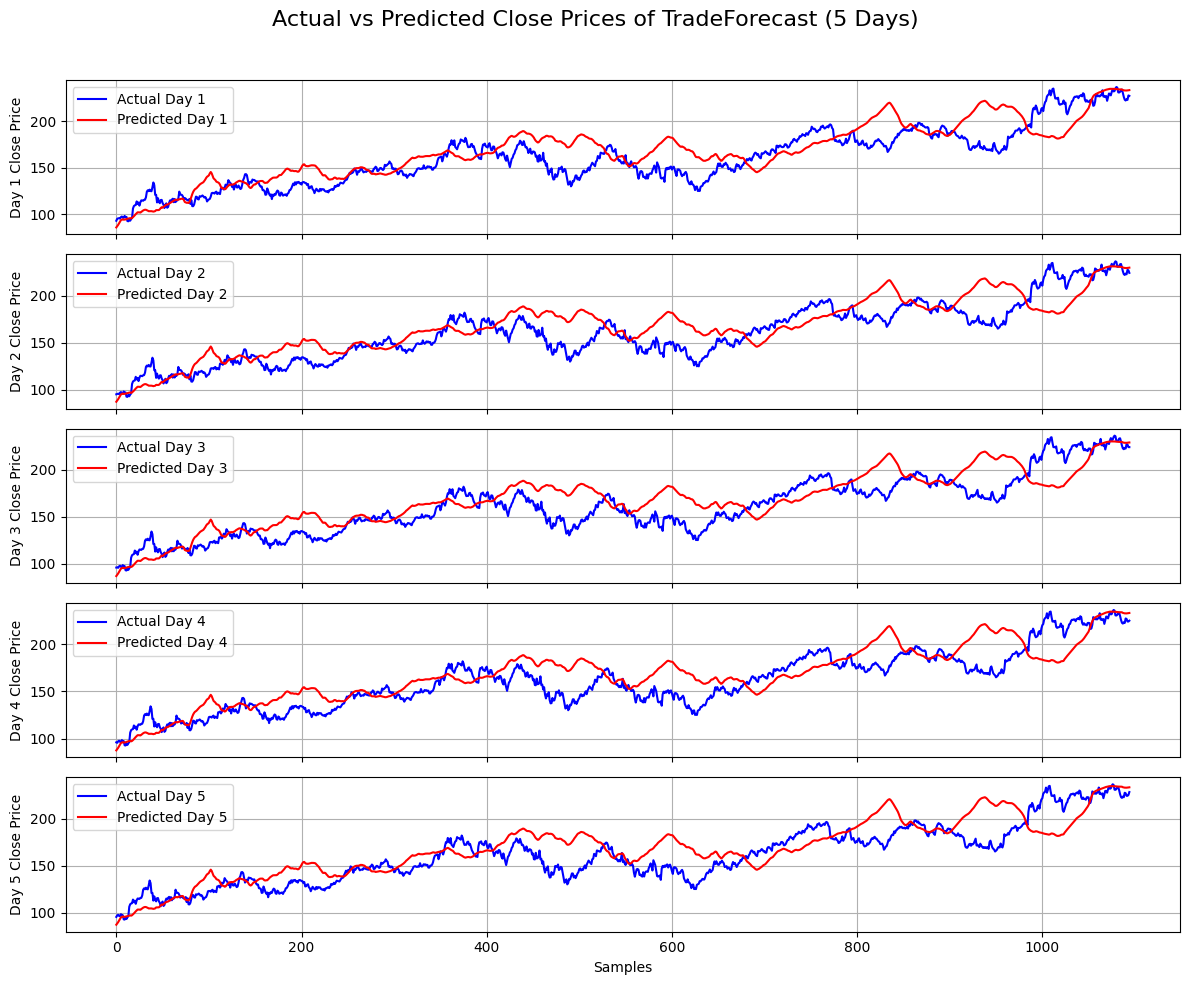

In [7]:
from tradeforecast.viz import plot_rnn_forecasts

plot_rnn_forecasts(y_arr, y_preds_arr)